In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../housing.csv')
df.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df = df.fillna(0)

In [4]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [5]:
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
df = df.reset_index(drop = True)

In [6]:
df_full_train, df_test = train_test_split(df, test_size = 0.2,
                                          random_state = 11)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25,
                                    random_state = 11)

df_full_train = df_full_train.reset_index(drop = True)
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

y_full_train_orig = df_full_train.median_house_value.values
y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_full_train = np.log1p(y_full_train_orig)
y_train = np.log1p(y_train_orig)
y_val = np.log1p(y_val_orig)
y_test = np.log1p(y_test_orig)

del df_full_train['median_house_value']
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [11]:
train_dicts = df_train.to_dict(orient = 'records')
dv = DictVectorizer(sparse = False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

### Question 1

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [13]:
dt = DecisionTreeRegressor(max_depth = 1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [15]:
print(export_text(dt, feature_names = dv.get_feature_names_out()))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.62]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.29]



Which feature is used for splitting the data?

- **ocean_proximity**
- total_rooms
- latitude
- population

### Question 2

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [26]:
rf = RandomForestRegressor(n_estimators = 10, random_state = 1,
                          n_jobs = -1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [27]:
y_pred = rf.predict(X_val)
mean_squared_error(y_val, y_pred, squared = False)

0.23996903828204827

What's the RMSE of this model on validation?

- 0.045
- **0.245**
- 0.545
- 0.845

### Question 2

In [33]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators = n, random_state = 1,
                          n_jobs = -1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = mean_squared_error(y_val, y_pred, squared = False)
    
    scores.append((n, score))
    print('%3s -> %.3f' % (n, score))

 10 -> 0.240
 20 -> 0.233
 30 -> 0.232
 40 -> 0.230
 50 -> 0.230
 60 -> 0.230
 70 -> 0.230
 80 -> 0.230
 90 -> 0.230
100 -> 0.230
110 -> 0.229
120 -> 0.229
130 -> 0.229
140 -> 0.229
150 -> 0.229
160 -> 0.229
170 -> 0.228
180 -> 0.228
190 -> 0.228
200 -> 0.228


In [35]:
columns = ['n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,n_estimators,rmse
0,10,0.239969
1,20,0.232802
2,30,0.231530
3,40,0.230200
4,50,0.230209
5,60,0.229981
6,70,0.229975
7,80,0.229732
8,90,0.229558
9,100,0.229773


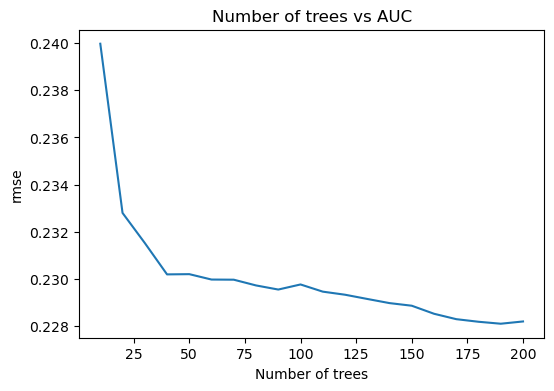

In [39]:
plt.figure(figsize=(6, 4))

plt.plot(df_scores.n_estimators, df_scores.rmse)
# plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))


plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('rmse')

plt.show()

After which value of n_estimators does RMSE stop improving?

- 10
- 25
- 50
- **160 (approximately)**

In [40]:
from tqdm.auto import tqdm

`warm_start=True` allows to add more trees to an existing random forest without starting from scratch, making it faster to train and experiment with different numbers of trees. It builds on the knowledge gained from the previously trained trees, so you can incrementally improve your model's performance.

In [41]:
scores = []

rf = RandomForestRegressor(
    n_estimators=1,
    random_state=1,
    n_jobs=-1,
    warm_start=True,
)

for n in tqdm(range(10, 201, 10)):
    rf.n_estimators = n
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

  0%|          | 0/20 [00:00<?, ?it/s]

In [42]:
columns = ['n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,n_estimators,rmse
0,10,0.239969
1,20,0.232802
2,30,0.231530
3,40,0.230200
4,50,0.230209
5,60,0.229981
6,70,0.229975
7,80,0.229732
8,90,0.229558
9,100,0.229773


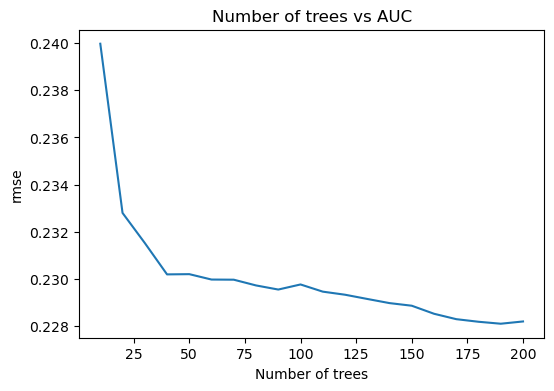

In [43]:
plt.figure(figsize=(6, 4))

plt.plot(df_scores.n_estimators, df_scores.rmse)
# plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))


plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('rmse')

plt.show()

### Question 4: Tuning the `max_depth` parameter

In [44]:
scores = []

for depth in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(
        n_estimators=1,
        max_depth = depth,
        random_state=1,
        n_jobs=-1,
        warm_start=True,
    )

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((depth, n, score))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [49]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,max_depth,n_estimators,rmse
0,10,10,0.247472
1,10,20,0.244112
2,10,30,0.242953
3,10,40,0.241990
4,10,50,0.241544
...,...,...,...
75,25,160,0.228195
76,25,170,0.227945
77,25,180,0.227906
78,25,190,0.227767


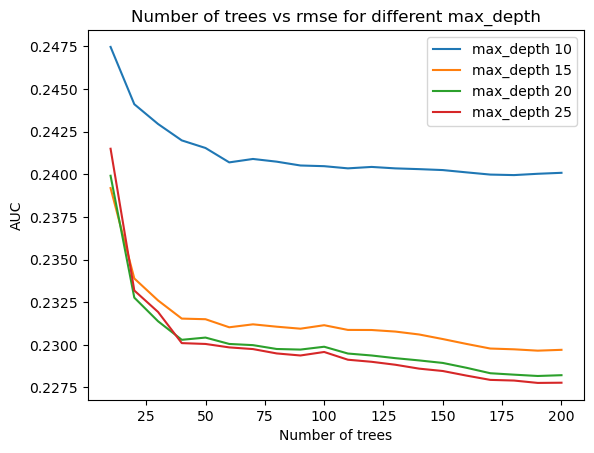

In [47]:
for depth in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == depth]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label = f'max_depth {depth}')

plt.title('Number of trees vs rmse for different max_depth')
plt.xlabel('Number of trees')
plt.ylabel('AUC')
plt.legend()

What's the best max_depth, using the mean RMSE?

- 10
- 15
- 20
- **25**

### Question 5

In [53]:
rf = RandomForestRegressor(
    n_estimators=175,
    max_depth = 25,
    random_state=1,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, n_estimators=175, n_jobs=-1, random_state=1)

In [54]:
y_pred = rf.predict(X_val)
score = np.sqrt(mean_squared_error(y_val, y_pred))
score

0.22797314680543768

In [59]:
df_importance = pd.DataFrame()
df_importance['feature'] = dv.get_feature_names_out()
df_importance['importance'] = rf.feature_importances_
df_importance.sort_values(by = 'importance', ascending = False)

,feature,importance
4,median_income,0.346282
5,ocean_proximity=<1H OCEAN,0.220541
6,ocean_proximity=INLAND,0.124702
2,latitude,0.102173
3,longitude,0.088670
1,housing_median_age,0.032439
7,population,0.029360
9,total_rooms,0.021855
0,households,0.017355
8,total_bedrooms,0.016623


What's the most important feature (among these 4)?

- `total_rooms`
- **`median_income`**
- `total_bedrooms`
- `longitude`

### Question 6

In [61]:
import xgboost as xgb

In [67]:
features = dv.get_feature_names_out()
features = [f.replace('<', 'less ') for f in features]
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=less 1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [68]:
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = features)
dval = xgb.DMatrix(X_val, label = y_val, feature_names = features)

In [69]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'verbosity': 1,
    'seed': 1
}
model = xgb.train(xgb_params, dtrain,
                  verbose_eval = 5,
                  num_boost_round = 200)

In [71]:
y_pred = model.predict(dval)
score = np.sqrt(mean_squared_error(y_val, y_pred))
score

0.21824683638553655

In [72]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [73]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'verbosity': 1,
    'seed': 1
}
model = xgb.train(xgb_params, dtrain, evals = watchlist,
                  verbose_eval = 5,
                  num_boost_round = 200)

[0]	train-rmse:8.06992	val-rmse:8.07823
[5]	train-rmse:1.38875	val-rmse:1.39181
[10]	train-rmse:0.32722	val-rmse:0.34304
[15]	train-rmse:0.21450	val-rmse:0.24441
[20]	train-rmse:0.19319	val-rmse:0.23319
[25]	train-rmse:0.18497	val-rmse:0.23020
[30]	train-rmse:0.17820	val-rmse:0.22754
[35]	train-rmse:0.17124	val-rmse:0.22720
[40]	train-rmse:0.16558	val-rmse:0.22520
[45]	train-rmse:0.15933	val-rmse:0.22363
[50]	train-rmse:0.15345	val-rmse:0.22250
[55]	train-rmse:0.14853	val-rmse:0.22176
[60]	train-rmse:0.14451	val-rmse:0.22093
[65]	train-rmse:0.14145	val-rmse:0.22045
[70]	train-rmse:0.13725	val-rmse:0.22055
[75]	train-rmse:0.13451	val-rmse:0.21991
[80]	train-rmse:0.13081	val-rmse:0.21964
[85]	train-rmse:0.12775	val-rmse:0.21941
[90]	train-rmse:0.12513	val-rmse:0.21902
[95]	train-rmse:0.12216	val-rmse:0.21883
[100]	train-rmse:0.11882	val-rmse:0.21848
[105]	train-rmse:0.11633	val-rmse:0.21872
[110]	train-rmse:0.11311	val-rmse:0.21864
[115]	train-rmse:0.11017	val-rmse:0.21820
[120]	train-rm

In [74]:
%%capture output
model = xgb.train(xgb_params, dtrain, evals = watchlist,
                  verbose_eval = 5,
                  num_boost_round = 200)

In [75]:
print(output.stdout)

[0]	train-rmse:8.06992	val-rmse:8.07823
[5]	train-rmse:1.38875	val-rmse:1.39181
[10]	train-rmse:0.32722	val-rmse:0.34304
[15]	train-rmse:0.21450	val-rmse:0.24441
[20]	train-rmse:0.19319	val-rmse:0.23319
[25]	train-rmse:0.18497	val-rmse:0.23020
[30]	train-rmse:0.17820	val-rmse:0.22754
[35]	train-rmse:0.17124	val-rmse:0.22720
[40]	train-rmse:0.16558	val-rmse:0.22520
[45]	train-rmse:0.15933	val-rmse:0.22363
[50]	train-rmse:0.15345	val-rmse:0.22250
[55]	train-rmse:0.14853	val-rmse:0.22176
[60]	train-rmse:0.14451	val-rmse:0.22093
[65]	train-rmse:0.14145	val-rmse:0.22045
[70]	train-rmse:0.13725	val-rmse:0.22055
[75]	train-rmse:0.13451	val-rmse:0.21991
[80]	train-rmse:0.13081	val-rmse:0.21964
[85]	train-rmse:0.12775	val-rmse:0.21941
[90]	train-rmse:0.12513	val-rmse:0.21902
[95]	train-rmse:0.12216	val-rmse:0.21883
[100]	train-rmse:0.11882	val-rmse:0.21848
[105]	train-rmse:0.11633	val-rmse:0.21872
[110]	train-rmse:0.11311	val-rmse:0.21864
[115]	train-rmse:0.11017	val-rmse:0.21820
[120]	train-rm

In [80]:
def parse_xgb_output(output):
    results = []
    tree = []
    rmse_train = []
    rmse_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        tree.append(it)
        rmse_train.append(train)
        rmse_val.append(val)
        
        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns = columns)
    return df_results

In [81]:
df_scores = parse_xgb_output(output)
df_scores

,num_iter,train_rmse,val_rmse
0,0,8.06992,8.07823
1,5,1.38875,1.39181
2,10,0.32722,0.34304
3,15,0.21450,0.24441
4,20,0.19319,0.23319
5,25,0.18497,0.23020
6,30,0.17820,0.22754
7,35,0.17124,0.22720
8,40,0.16558,0.22520
9,45,0.15933,0.22363


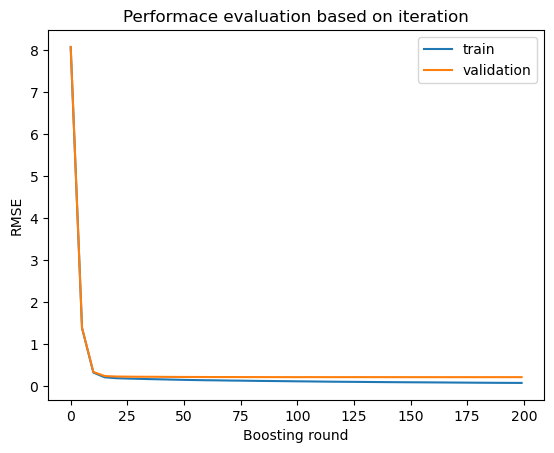

In [82]:
plt.plot(df_scores.num_iter, df_scores.train_rmse, label = 'train')
plt.plot(df_scores.num_iter, df_scores.val_rmse, label = 'validation')

plt.title('Performace evaluation based on iteration')
plt.xlabel('Boosting round')
plt.ylabel('RMSE')
plt.legend()

#### Tuning the eta for 0.3 and 0.1

In [83]:
scores = {}
# for eta: 0.3, 0.1

In [88]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'verbosity': 1,
    'seed': 1
}

In [89]:
%%capture output
model = xgb.train(xgb_params, dtrain, evals = watchlist,
                  verbose_eval = 5,
                  num_boost_round = 200)

In [90]:
key = f"eta={xgb_params['eta']}"
scores[key] = parse_xgb_output(output)

In [91]:
scores.keys()

dict_keys(['eta=0.3', 'eta=0.1'])

In [92]:
scores['eta=0.3']

,num_iter,train_rmse,val_rmse
0,0,8.06992,8.07823
1,5,1.38875,1.39181
2,10,0.32722,0.34304
3,15,0.21450,0.24441
4,20,0.19319,0.23319
5,25,0.18497,0.23020
6,30,0.17820,0.22754
7,35,0.17124,0.22720
8,40,0.16558,0.22520
9,45,0.15933,0.22363


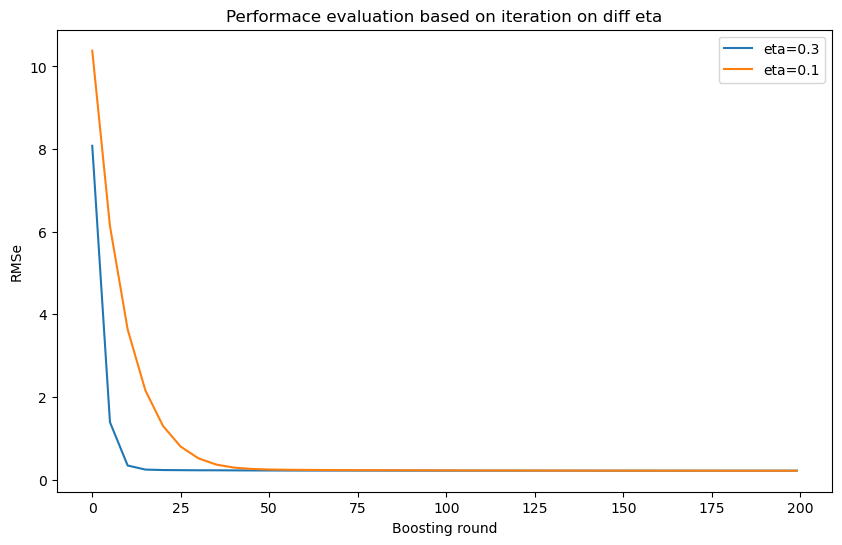

In [93]:
plt.figure(figsize=(10, 6))
for key, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.val_rmse, label = f'{key}')

    plt.title('Performace evaluation based on iteration on diff eta')
    plt.xlabel('Boosting round')
    plt.ylabel('RMSe')
plt.legend()

Which eta leads to the best RMSE score on the validation dataset?

- **0.3**
- 0.1
- Both give equal value